In [ ]:
from infrastructure.classes import Experiment, TrainParameters
from infrastructure.training import train
from pushforward_operators import AmortizedNeuralQuantileRegression, NeuralQuantileRegression, EntropicNeuralQuantileRegression
import torch

experiment = Experiment(
    tensor_parameters=dict(dtype=torch.float32, device=torch.device("cpu")),
    dataset_name="fnlvqr_glasses",
    dataset_number_of_points=10**6,
    dataset_parameters=dict(),
    dataloader_parameters=dict(batch_size=256, shuffle=True),
    pushforward_operator_name="amortized_neural_quantile_regression",
    pushforward_operator_parameters=dict(
        feature_dimension=1,
        response_dimension=1,
        hidden_dimension=55,
        number_of_hidden_layers=8,
        potential_to_estimate_with_neural_network="u",
    ),
    train_parameters=TrainParameters(
        number_of_epochs_to_train=10,
        verbose=True,
        optimizer_parameters=dict(
            lr=1e-3,
            weight_decay=1e-4,
            betas=(0.5, 0.5)  
        ),
        scheduler_parameters=dict(eta_min=0),
        warmup_iterations=1,
    )
)

model = train(experiment)
_ = model.eval()

Warm up iteration: 1 Potential loss: 0.034, Amortization loss: 0.020: 100%|██████████| 1/1 [00:43<00:00, 43.16s/it]
Epoch: 5, Potential Objective: 0.798, Amortization Objective: 0.388, Potential LR: 0.000646, Amortized LR: 0.000275:  40%|████      | 4/10 [28:59<44:30, 445.14s/it]

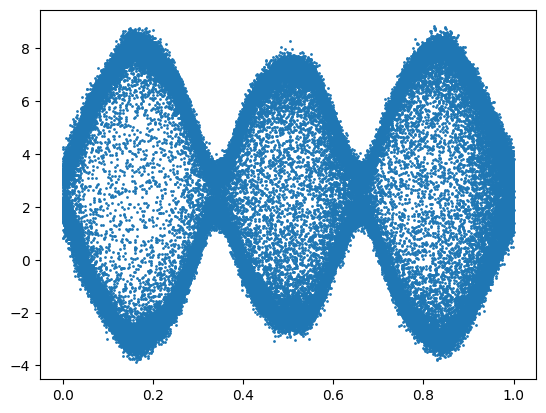

In [ ]:
import matplotlib.pyplot as plt
from datasets import FNLVQR_Glasses

model.to(**experiment.tensor_parameters)
dataset = FNLVQR_Glasses(experiment.tensor_parameters)
X, Y = dataset.sample_joint(100000)
X = X.to(**experiment.tensor_parameters)
Y = Y.to(**experiment.tensor_parameters)
U = torch.randn_like(Y)
Y_approx = model.push_u_given_x(U, X)

plt.scatter(X[:, 0], Y_approx[:, 0], s=1)
# plt.scatter(X[:, 0], Y[:, 0], s=1)
plt.show()

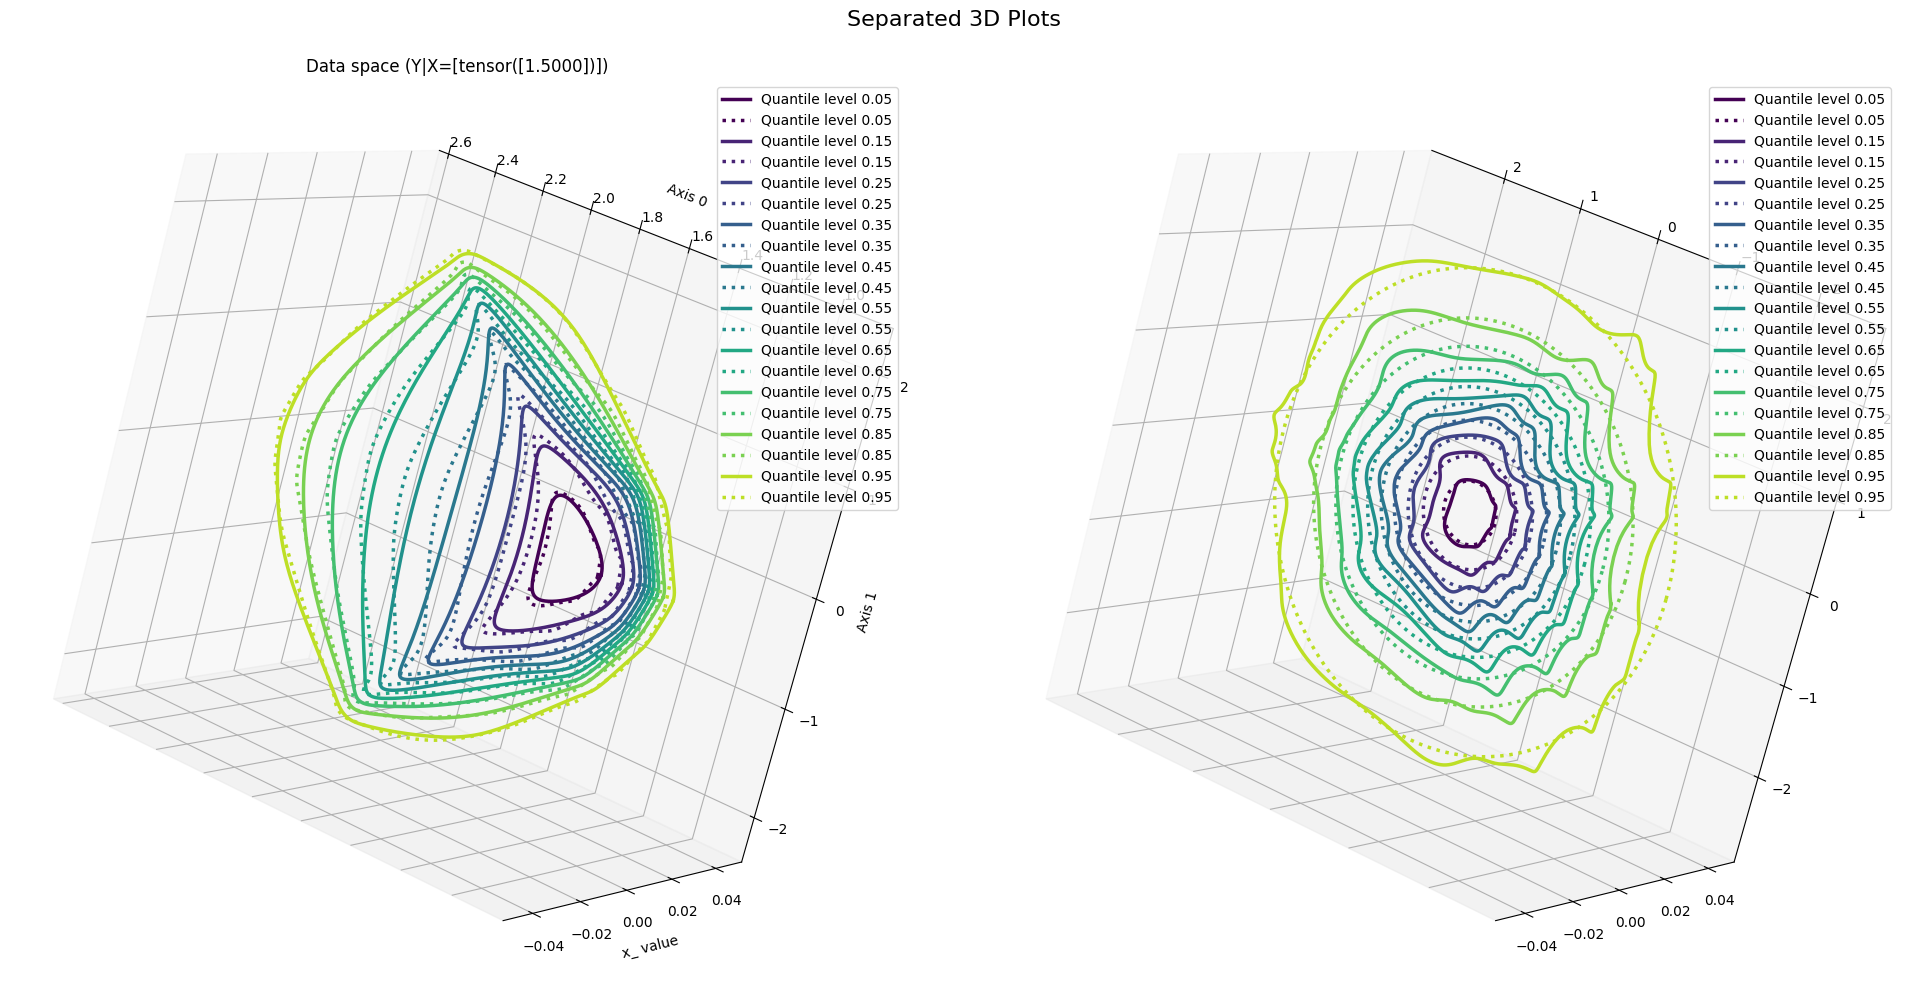

In [34]:
%matplotlib inline
from datasets import PICNN_FNLVQR_Star, PICNN_FNLVQR_Banana
from utils.plot import plot_quantile_levels_from_dataset

dataset = PICNN_FNLVQR_Banana(tensor_parameters=experiment.tensor_parameters)
plot_quantile_levels_from_dataset(
    model=model,
    dataset=dataset,
    conditional_value=torch.tensor([[1.5]]),
    number_of_quantile_levels=10,
    tensor_parameters=experiment.tensor_parameters
)